# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import itertools
import traceback
import tifffile as tiff
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import marsilea as ma
import marsilea.plotter as mp
import anndata
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import corescpy as cr

sc.set_figure_params(transparent=True, dpi=200, dpi_save=200,
                     figsize=(20, 20), frameon=False)

# Main
panel = "TUQ97N"  # Xenium panel ID
capitalize_sample = panel == "TUQ97N"
read_full_obj = False  # must be True to plot spatial; False = faster
file_markers = os.path.join("~/corescpy/examples/markers_lineages.csv")
col_markers = "Bucket"
direc = "/mnt/cho_lab/bb-xenium-registry"  # mounted NFS with data
dir_entry = "/mnt/cho_lab/disk2"  # Spark writeable data directory
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
          f"samples_{panel}.csv")  # metadata file path
dir_writeable = os.path.join(
    dir_entry, f"elizabeth/data/shared-xenium-library")  # where objects are
out_dir = os.path.join(
    dir_writeable, f"outputs/{panel}/nebraska")  # object output directory
out_new = out_dir
# out_new = ?  # specify cropped objects output directory
out_sub = os.path.join(out_new, "objects_cropped")  # cropped objects
dir_he = os.path.join(out_dir, f"tissue-registry/xenium/{panel}/he/ome-tiff")

# Process Options
col_cell_type = "leiden_res1pt5_dist0_npc30"
layer = "counts"
layer_log1p = "log1p"
layer_mat = "scaled"
col_ann = "lump"
col_cluster = col_ann + "_" + col_cell_type.split("leiden_")[1]
regions = ["mucosa", "submucosa", "myenteric_plexus",
           "smc_circular", "smc_longitudinal", "serosa"]
# palette = "tab20"
palette = "TUQ97N"  # TUQ97N-specific color-coding for conditions
genes_dict = {
    "CD Risk": ["NOD2", "LACC1", "LRRK2", "PTGER4"],
    "SnC": ["CDKN2A", "CDKN1A", "TP53", "PLAUR", "PLAU", "BCL2"],
    "SASP": ["IL4", "IL13", "IL1A", "CXCL8", "CCL2", "CEBPB", "NFKB1",
             "TGFB1", "IGFBP7", "OSM", "IL6", "IL6ST"],
    "Fibrosis": ["SUCNR1", "CXCR4", "IL33", "IL1B", "IL11", "IFNG",
                 "IL22", "IL10", "IL21", "IL34", "CCL11"],
    "ER Stress/UPR": ["ATF4"],
    "Autophagy": ["MTOR", "ATG3", "ATG5", "ATG7", "ATG12", "ATG16L1",
                  "SQSTM1", "BECN1"],
    "DNA Repair": ["ERCC1", "ERCC4"],
    "Healing": ["GREM1", "LCN2", "MMP9", "PDGFRA"],
    # "Mixed": ["ICAM1"]
}
# genes_dict = {
#     "TH1": ["CD3D", "CD3E", "IFNG", "IFNGR2", "STAT4", "TBX21", "CD4"],
#     "TH2": ["CD14", "CXCR4", "IL4", "STAT5A", "STAT5B", "IL10", "IL13"],
#     "TH17/Treg": ["CCL20", "IL21", "IL22", "IL23R",
#                   "RORC", "TGFB1", "STAT3"]
# }

# gene_combos = [["PLAUR", "PLAU"], ["CDKN1A", "TP53"]]
# gene_combos = [["CDKN1A", i] for i in [
#     "TP53", "PLAU", "PLAUR", "IL6", "IL6ST", "OSM"]] + [[
#         "CDKN1A", "TP53", "PLAUR"], ["CDKN1A", "TP53", "PLAU"], [
#             "PLAU", "PLAUR"], ["OSM", "IL6ST"], ["IL11", "IL6ST"]]
gene_combos = [["PLAUR", x] for x in [
    "PDGFRA", "IL6", "IL10", "TGFB1", "IL6ST", "PTGER4"]]  # Helmsley aim
# gene_combos = [genes_dict[x] for x in genes_dict]

# genes_cat_colors = None
# genes_dict_colors = ["#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
#                      "#FFC0CB", "#A52A2A", "#800080", "#008000", "#808080"]
genes_dict_colors = ["#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
                     "#FFC0CB", "#A52A2A", "#800080", "#008000",
                     # "#808080"
                     ]
if len(genes_dict) < len(genes_dict_colors):
    genes_dict_colors = genes_dict_colors[:len(genes_dict)]
if genes_dict is not None and len(genes_dict) != len(genes_dict_colors):
    raise ValueError("`genes_dict_colors` must have the same length as "
                     "the number of categories/keys in `genes_dict`!")
genes = list(pd.unique(functools.reduce(lambda u, v: u + v, [
    genes_dict[x] for x in genes_dict])))
# libs = [  # sample IDs from patients for whom we have all conditions
#     "50452A", "50452B", "50452C",  # old segmentation
#     "50006A", "50006B", "50006C",  # rest are new segmentation
#     "50217A", "50217B", "50217C",
#     "50336B", "50336C", "50336A",
#     "50403A2", "50403B", "50403C1"
# ]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
# libs = ["50006A", "50006B", "50217A", "50217B", "50336B", "50336C",
#         "50403B", "50403A2"]  # just inflamed/uninflamed (no strictures)
libs = None  # to run all available samples
input_suffix = ""  # in case want to crop objects with some suffix
# due to creation of a subsidiary object, e.g., for
# "Stricture-50452C_downsampled.h5ad"
# input_suffix would be "_downsampled". For "main" objects, input_suffix=""
plot = True  # could slow process down if large samples/cropped area

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
constants_dict = cr.get_panel_constants(panel)
cso, col_sample, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, key_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "key_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]
show_cols = [col_subject]  # only change if not TUQ97N
dir_data = os.path.join(direc, f"outputs/{panel}")
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel, samples=libs,
                                  capitalize_sample=capitalize_sample)
if palette == "TUQ97N":
    palette = dict(zip([constants_dict[x] for x in [
        "key_uninflamed", "key_inflamed", "key_stricture"]],
                       ["blue", "red", "yellow"]))
    hue_order = list(palette.keys())
else:
    hue_order = list(palette.keys()) if isinstance(palette, dict) else None

# Annotations
f_ann = pd.read_excel(os.path.join(
    out_dir, "annotation_dictionaries/annotations_all.xlsx"), index_col=[
        0, 1, 2]).dropna(how="all").dropna(how="all", axis=1)
annots = f_ann.copy()
annots = annots.reset_index().astype({annots.index.names[2]: "int"}).astype({
    annots.index.names[2]: "string"}).reset_index()
annots.loc[:, f_ann.index.names[2]] = pd.Categorical(annots[
    f_ann.index.names[2]])
annots = annots.set_index(f_ann.index.names)
mks = pd.read_csv(file_markers, index_col=0).groupby(col_markers).apply(
    lambda x: list(x.index.values))  # cell type marker dictionary
mks = pd.read_csv(file_markers, index_col=0).replace({
    "DC": "Myeloid", "ILC": "T Cell", "Neural-Glia": "Neuron-Glia",
    "Epithelial (Stem/TA)": "Epithelial (Stem/TA/Paneth)",
    "Enteroendocrine": "Epithelial", "Secretory Epithelial": "Epithelial",
    "Granulocyte": "Myeloid", "SMC": "Myocytic"}).groupby(
    col_markers).apply(lambda x: list(x.index.values))
metadata[show_cols]

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

subject_id
Sample                        
Uninflamed-50403A2       50403
Uninflamed-50403A1       50403
Uninflamed-50336C        50336
Inflamed-50336B          50336
Stricture-50336A         50336
Stricture-50403C2        50403
Stricture-50403C1        50403
Inflamed-50403B          50403
Stricture-50217C         50217
Uninflamed-50217B        50217
Inflamed-50217A          50217
Stricture-50006C         50006
Uninflamed-50006B        50006
Inflamed-50006A          50006
Stricture-50445A3        50445
Stricture-50007B2        50007
Stricture-50115A2        50115
Stricture-49471A4        49471
Stricture-50618B5        50618
Stricture-50564A4        50564
Stricture-50452C         50452
Inflamed-50452B          50452
Uninflamed-50452A        50452

# Regions Plots

In [ ]:
for r in regions:
    samps = [s for s in metadata.groupby(col_condition).apply(
        lambda x: x.sort_values(col_subject), include_groups=False
        ).reset_index(0).index.values if os.path.exists(
            os.path.join(out_sub, r, f"{s}_{r}.h5ad"))]
    fig, axs = plt.subplots(*cr.pl.square_grid(len(samps)), figsize=(30, 30))
    for i, s in enumerate(samps):
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        sq.pl.spatial_scatter(
            adata, library_id="spatial", title=f"{s} {r}",
            fig=fig, ax=axs.flatten()[i], shape=None,
            color=[col_cell_type], wspace=0.4, legend_loc=None)
        axs.flatten()[i].set_title(s)
    fig.suptitle(r)
    fig.tight_layout()
    fig.show()
    fig.savefig(os.path.join(out_dir, "plots", f"clusters_region_{r}.jpeg"))

# H&E Plots (Optional)

## Just H&Es

In [ ]:
samps = [s for s in metadata.groupby(col_condition).apply(
    lambda x: x.sort_values(col_subject), include_groups=False
    ).reset_index(0).index.values if os.path.exists(
        os.path.join(out_sub, regions[0], f"{s}_{regions[0]}.h5ad"))]
fig, axs = plt.subplots(*cr.pl.square_grid(len(samps)), figsize=(30, 30))
for i, s in enumerate(samps):
    file_he = os.path.join(dir_he, f"{s}.ome.tif")
    if not os.path.exists(file_he):
        print(f"{file_he} doesn't exist!")
        continue
    image = tiff.imread(file_he)
    if "50403" in file_he or "50006" in file_he:
        split_point = int(img.shape[1] / float(3 if "50006" in s else 2))
        left, right = img[:, :, :split_point], img[:, :, split_point:]
        image = right if s in ["50403A1" or "50006A"] else left
    axs.flatten()[i].imshow(image)
    axs.flatten()[i].set_title(f"{s}", fontsize=20)
    axs.flatten()[i].axis("off")
    axs.flatten()[i].set_title(s)
fig.savefig(os.path.join(out_dir, "plots", f"hes_{'_'.join(samps)}.jpeg"))

## H&Es + Clusters

In [ ]:
samps = [s for s in metadata.groupby(col_condition).apply(
    lambda x: x.sort_values(col_subject), include_groups=False
    ).reset_index(0).index.values if os.path.exists(
        os.path.join(out_sub, regions[0], f"{s}_{regions[0]}.h5ad"))]
fig, axs = plt.subplots(2 + len(regions), len(samps), figsize=(30, 30))
for i, s in enumerate(samps):
    file_he = os.path.join(dir_he, f"{s}.ome.tiff")
    if not os.path.exists(file_he):
        continue
    image = tiff.imread(file_he)
    if "50403" in file_he or "50006" in file_he:
        split_point = int(img.shape[1] / float(3 if "50006" in s else 2))
        left, right = img[:, :, :split_point], img[:, :, split_point:]
        image = right if s in ["50403A1" or "50006A"] else left
    axs[0, i].imshow(image)
    axs[0, i].set_title(f"{s}", fontsize=20)
    axs[0, i].axis("off")
    axs[0, i].set_title(s)
    adata = sc.read_h5ad(os.path.join(out_dir, f"{s}.h5ad"))
    sq.pl.spatial_scatter(
        adata, library_id="spatial", title=f"{s}",
        fig=fig, ax=axs[1, i], shape=None,
        color=[col_cluster], wspace=0.4, legend_loc=None)
    for j, r in enumerate(regions):
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}.h5ad"))
        sq.pl.spatial_scatter(
            adata, library_id="spatial", title=f"{s} ({r})",
            fig=fig, ax=axs[j + 2, i], shape=None,
            color=[col_cluster], wspace=0.4, legend_loc=None)
    axs.flatten()[i].set_title(s)
fig.show()

# Cells

### Overall

In [11]:
%%time

cells_pos, cells_cox = {}, {}
for s in metadata.index:
    print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
    if not os.path.exists(os.path.join(out_dir, f"{s}.h5ad")):
        print(os.path.join(out_dir, f"{s}.h5ad") + " not found")
        continue
    adata = sc.read_h5ad(os.path.join(out_dir, f"{s}.h5ad"))
    if col_cell_type not in adata.obs:
        print(f"{col_cell_type} not found for {s}.")
        continue
    if annots is not None:
        if s not in annots.reset_index()[annots.index.names[0]].to_list():
            print(f"Annotations not found for {s}.")
            continue
        adata.obs = adata.obs.join(adata.obs[col_cell_type].map(dict(
            annots.loc[s].loc[col_cell_type][col_ann])).to_frame(col_ann))
    cells_pos[s] = cr.ax.classify_gex_cells(
        adata, col_cell_type=col_ann if annots is not None else col_cell_type,
        genes=list(set(genes).intersection(adata.var_names)))  # count + cells
    cells_cox[s] = cr.ax.classify_coex_cells(
        adata, col_cell_type=col_ann if annots is not None else col_cell_type,
        genes=gene_combos)
cells_pos = pd.concat(cells_pos, names=[col_sample]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)
cells_cox = pd.concat(cells_cox, names=[col_sample]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)
print(cells_cox)
cells_pos



	****************************************
	Uninflamed-50403A2
	****************************************




	****************************************
	Uninflamed-50403A1
	****************************************




	****************************************
	Uninflamed-50336C
	****************************************




	****************************************
	Inflamed-50336B
	****************************************




	****************************************
	Stricture-50336A
	****************************************




	****************************************
	Stricture-50403C2
	****************************************


Annotations not found for Stricture-50403C2.


	****************************************
	Stricture-50403C1
	****************************************




	****************************************
	Inflamed-50403B
	****************************************




	****************************************
	Stricture-50217C
	***************************************

{}

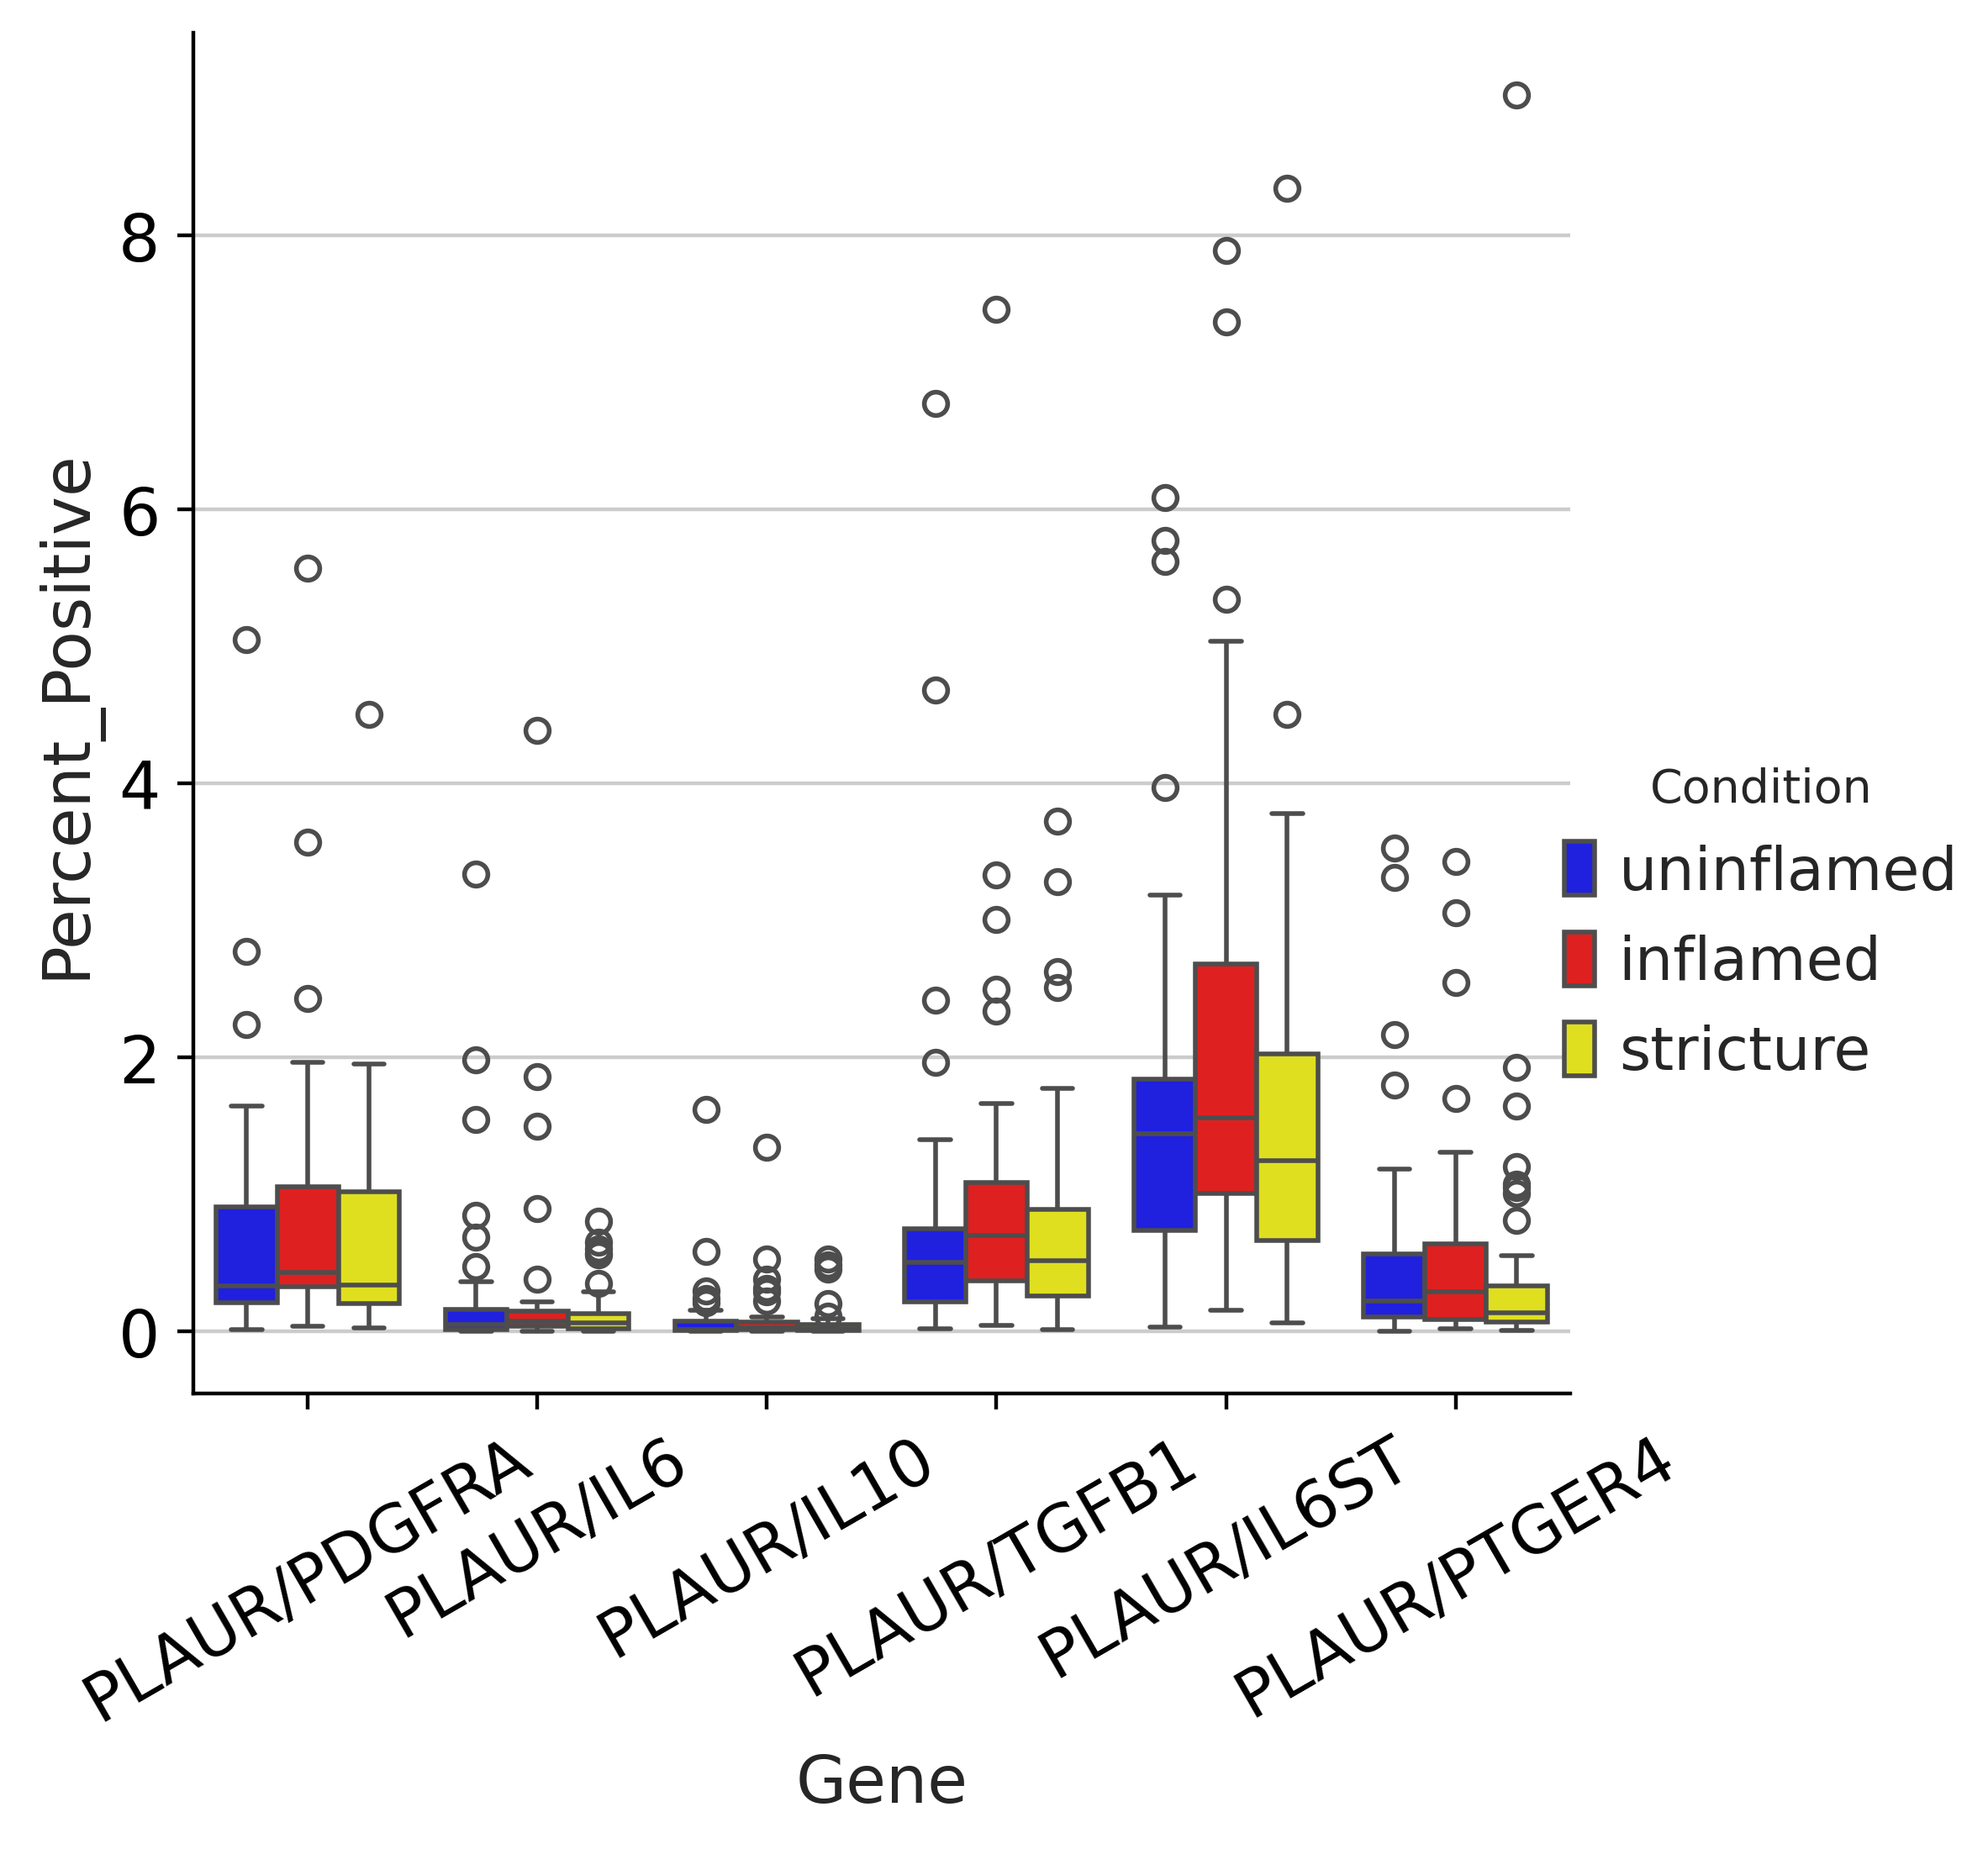

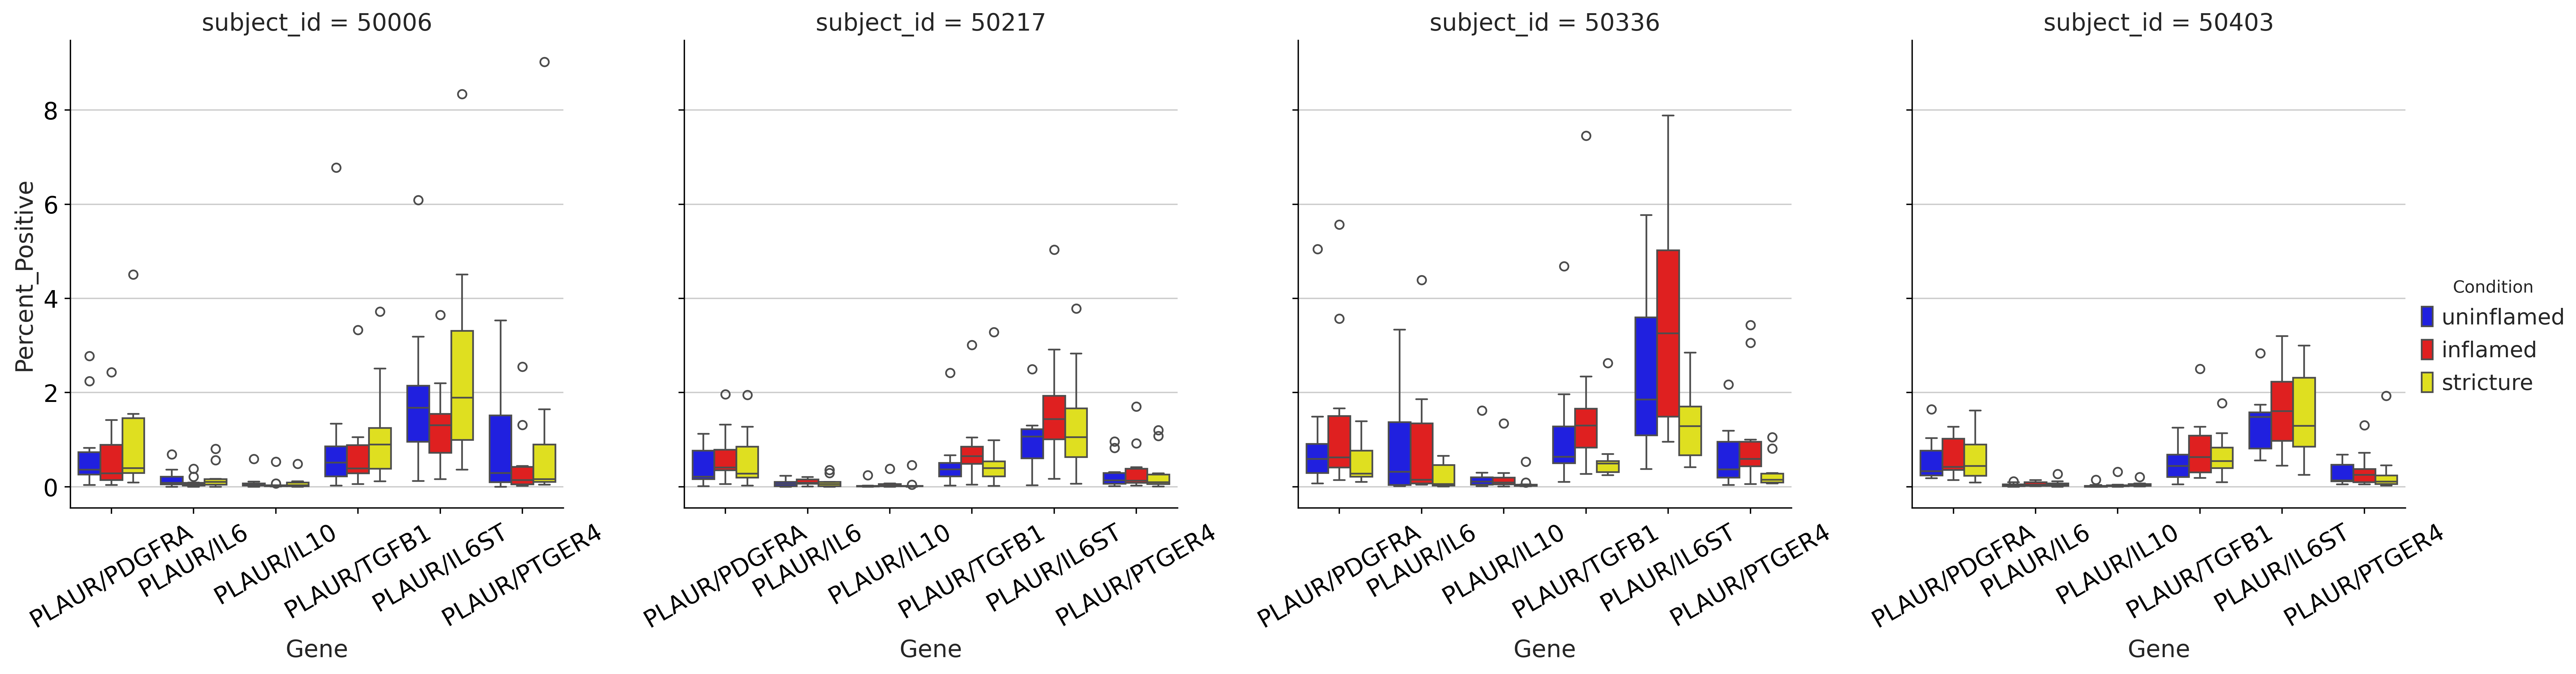

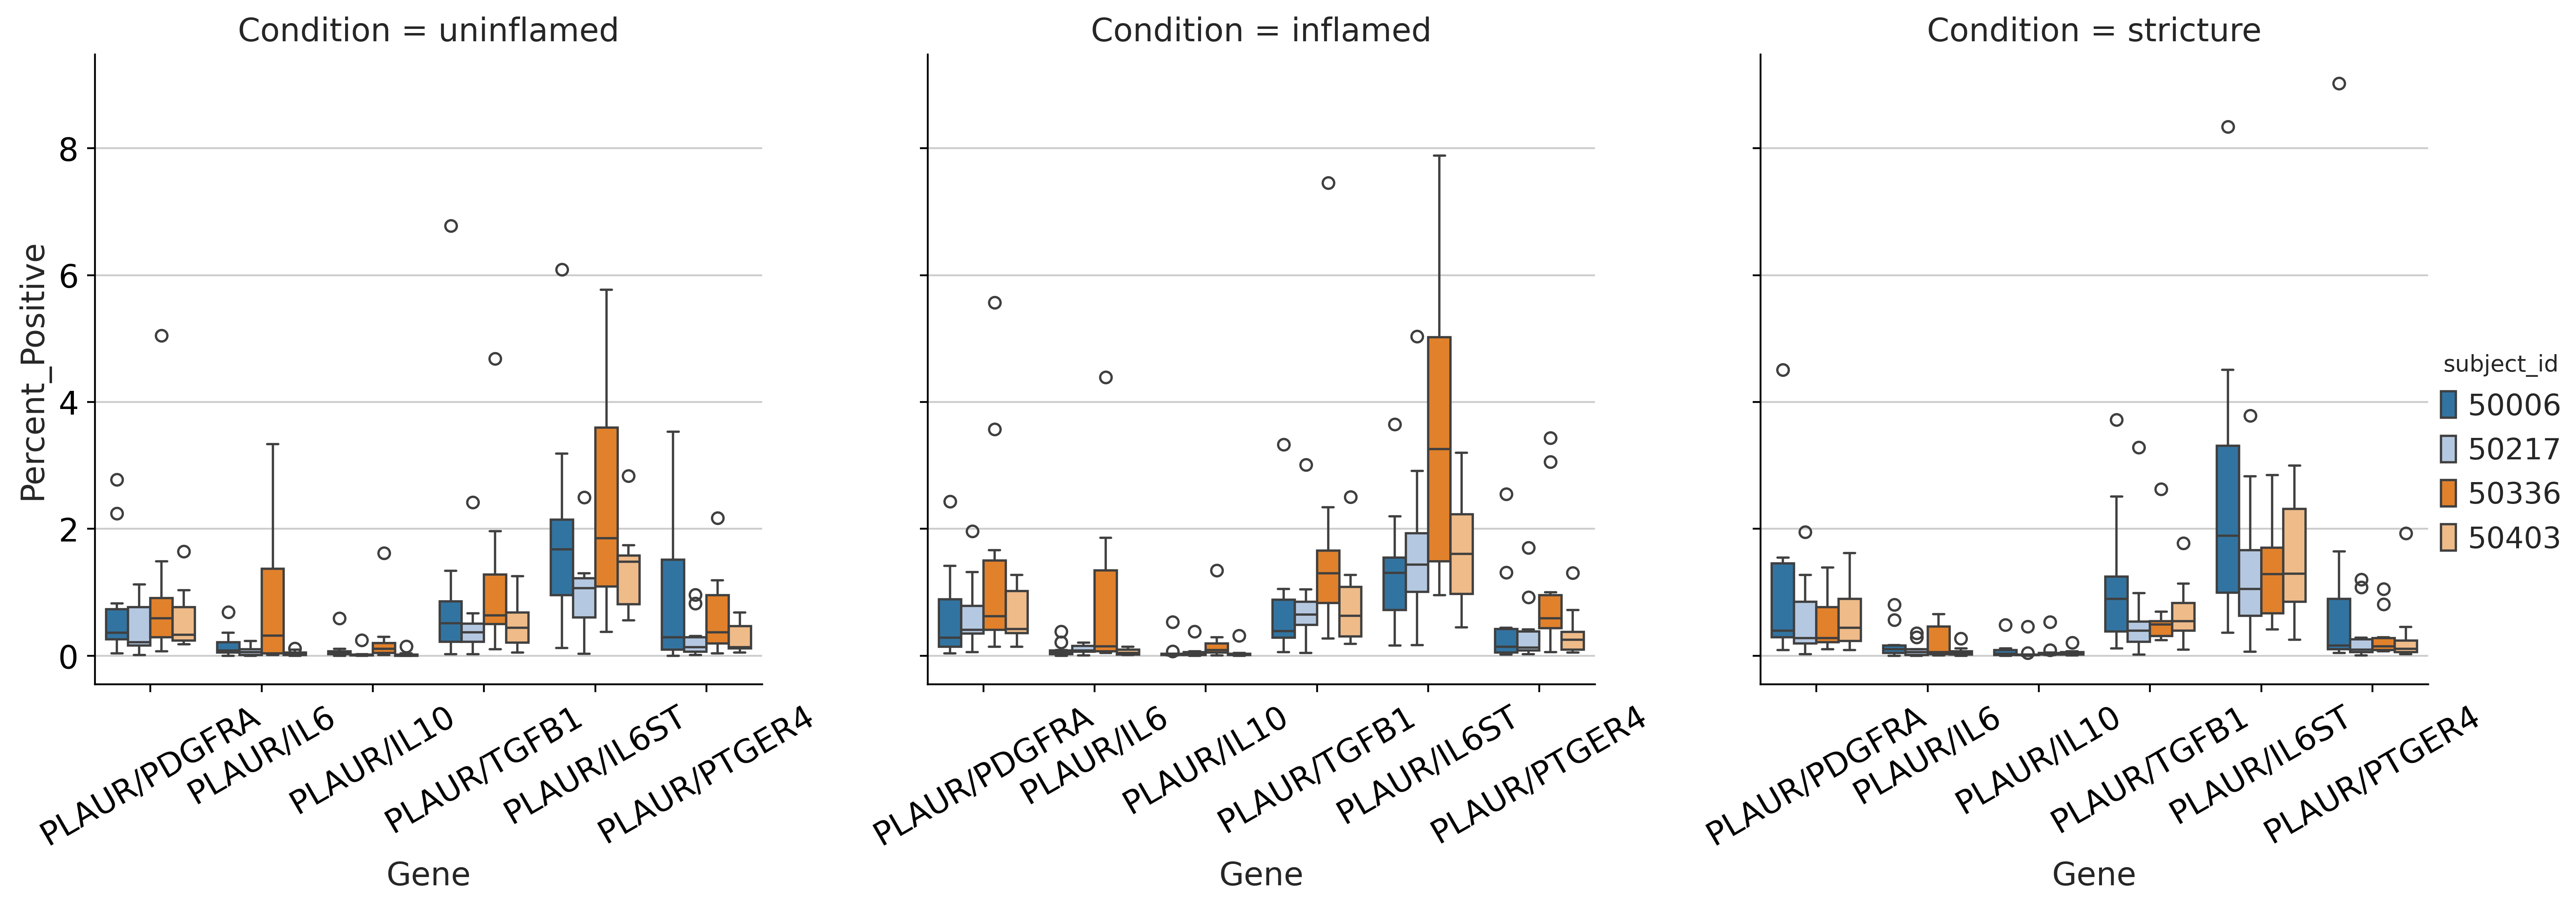

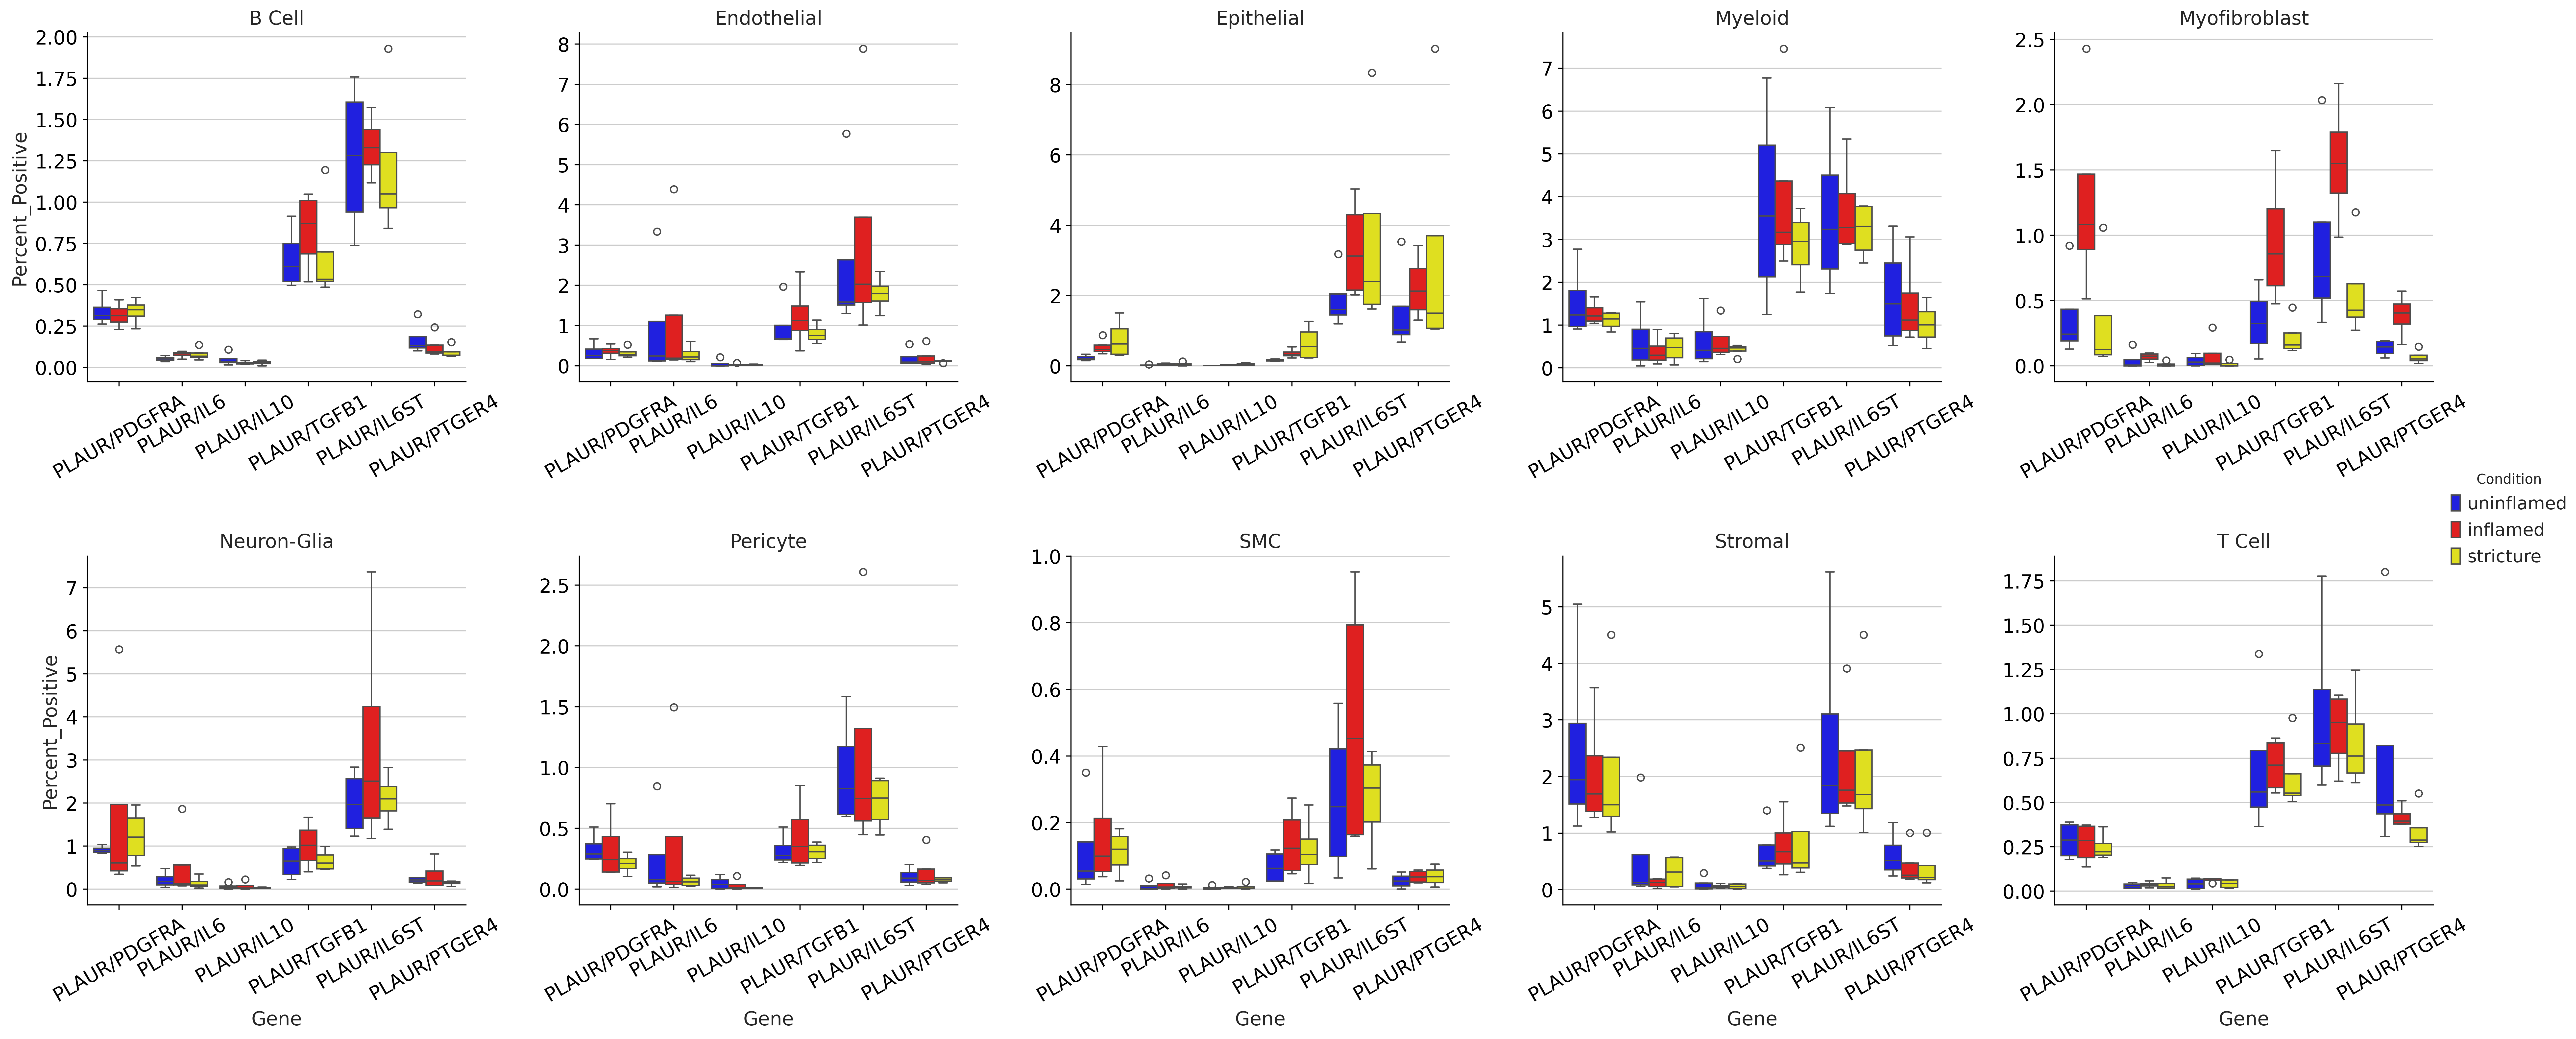

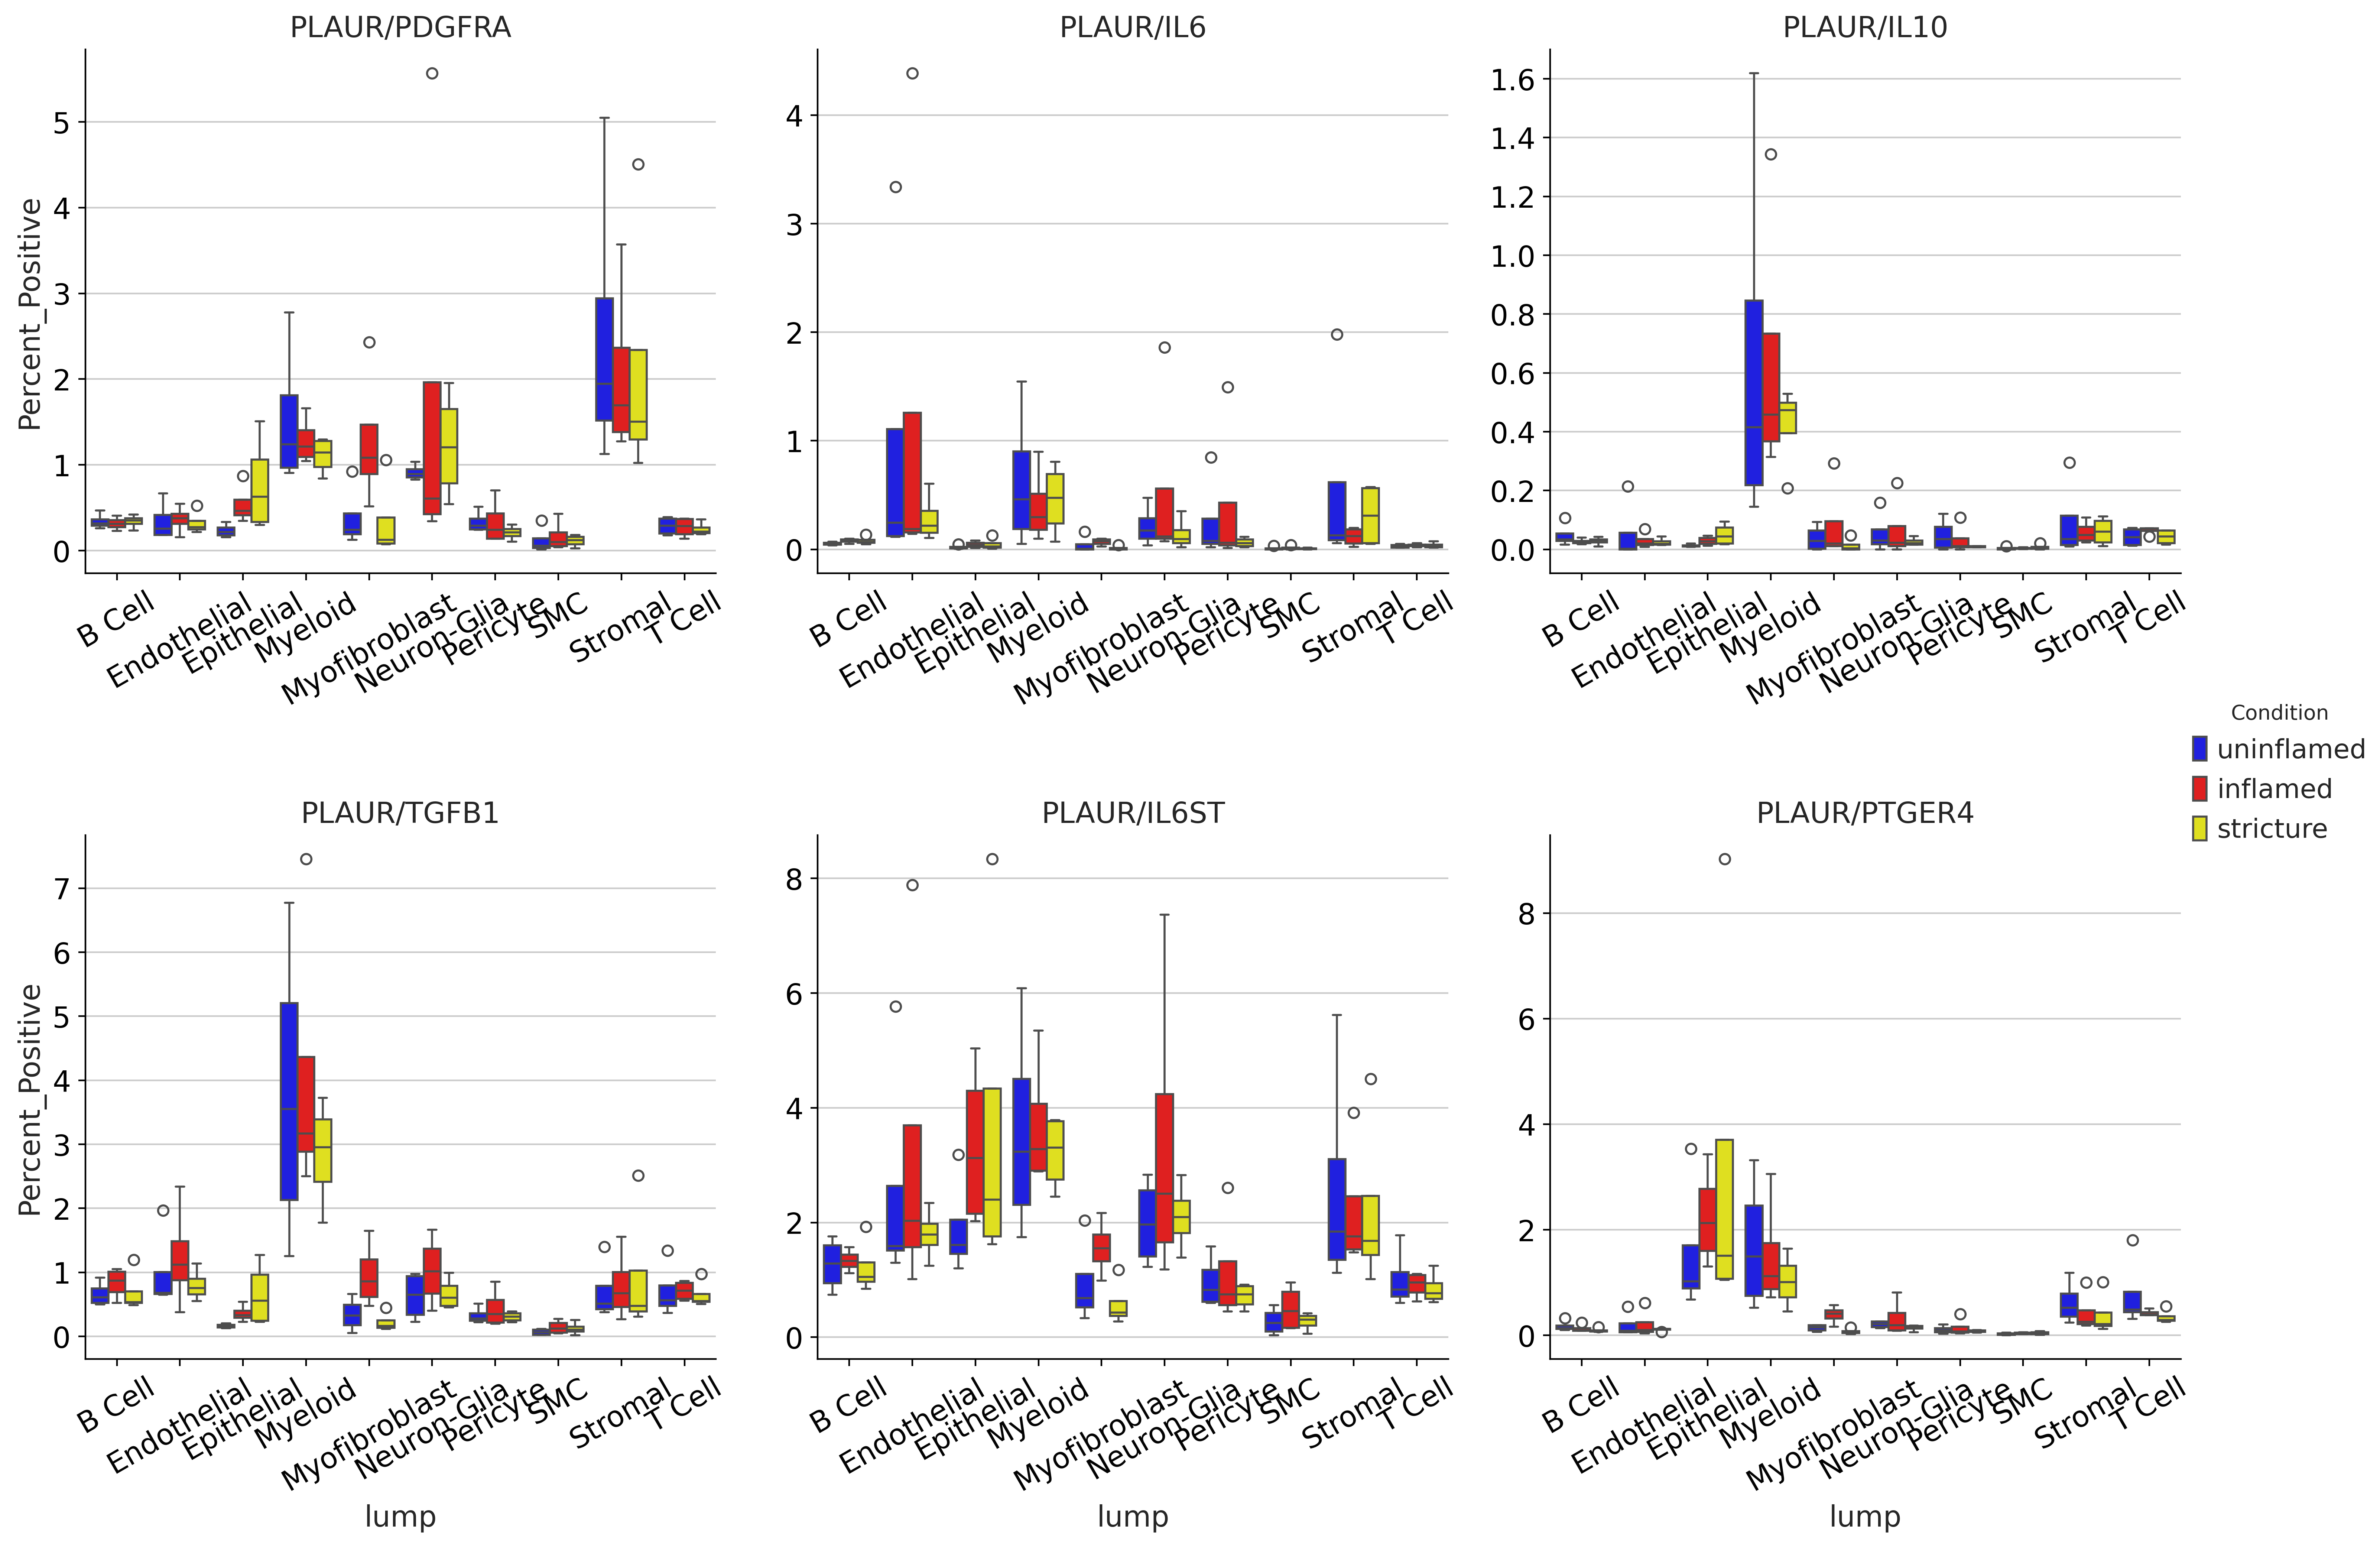

In [46]:
# cts = ["Epithelial", "Myeloid", "Myofibroblast",
#        "Stromal", "SMC", "Endothelial"]

fig = sb.catplot(cells_cox, kind="box", x="Gene",
                 y="Percent_Positive", hue=col_condition, palette=palette)
fig.set_xticklabels(rotation=30)

fig = sb.catplot(cells_cox, kind="box", x="Gene", col=col_subject,
                 y="Percent_Positive", hue=col_condition, palette=palette)
fig.set_xticklabels(rotation=30)

fig = sb.catplot(cells_cox, kind="box", x="Gene", hue=col_subject,
                 y="Percent_Positive", col=col_condition, palette="tab20")
fig.set_xticklabels(rotation=30)

fig = sb.catplot(cells_cox, kind="box", x="Gene",
                 sharex=False, sharey=False,
                 col_wrap=None if annots is None else 5,
                 row=col_subject if annots is None else None,
                 col=col_ann if annots is not None else col_cell_type,
                 y="Percent_Positive", hue=col_condition, palette=palette)
plt.subplots_adjust(hspace=0.5)
fig.set_titles(col_template="{col_name}")
fig.set_xticklabels(rotation=30)

fig = sb.catplot(cells_cox, kind="box", col="Gene",
                 x=col_ann if annots is not None else col_cell_type,
                 sharex=False, sharey=False,
                 col_wrap=None if annots is None else 3,
                 row=col_subject if annots is None else None,
                 y="Percent_Positive", hue=col_condition, palette=palette)
plt.subplots_adjust(hspace=0.5)
fig.set_titles(col_template="{col_name}")
fig.set_xticklabels(rotation=35)

In [5]:
# cells_pos.to_excel(os.path.join(out_dir, "quantification",
#                                 "n_cells_pos_XXXXXXXX"))
# cells_cox.to_excel(os.path.join(out_dir, "quantification",
#                                 "n_cells_pos_coex_XXXXXXXX"))

In [ ]:
%%time

cells_pos_check = {}
for s in metadata.index:
    print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
    if not os.path.exists(os.path.join(out_dir, f"{s}.h5ad")):
        print(os.path.join(out_dir, f"{s}.h5ad") + " not found")
        continue
    adata = sc.read_h5ad(os.path.join(out_dir, f"{s}.h5ad"))
    if col_cell_type not in adata.obs:
        print(f"{col_cell_type} not found for {s}.")
        continue
    g_s = list(set(genes).intersection(adata.var_names))
    cells_pos_check[s] = pd.Series([adata.var.loc[g][
        "n_cells_by_counts"] for g in g_s], index=pd.Index(g_s, name="Gene"))
cells_pos_check = pd.concat(cells_pos_check, names=[col_sample]).join(
    metadata[[col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)
cells_pos_check

### By Region

In [10]:
%%time

results, coexp = {}, {}
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    res, cox = {}, {}
    for s in metadata.index:
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        if not os.path.exists(os.path.join(out_sub, r, f"{s}_{r}.h5ad")):
            print(os.path.join(out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
            continue
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        if annots is not None:
            if s not in annots.reset_index()[annots.index.names[0]].to_list():
                print(f"Annotations not found for {s}.")
                continue
            adata.obs = adata.obs.join(adata.obs[col_cell_type].map(dict(
                annots.loc[s].loc[col_cell_type][col_ann])).to_frame(col_ann))
        res[s] = cr.ax.classify_gex_cells(
            adata, col_cell_type=col_cell_type if annots is None else col_ann,
            genes=list(set(genes).intersection(adata.var_names)))  # + cells
        cox[s] = cr.ax.classify_coex_cells(
            adata, col_cell_type=col_cell_type, genes=[list(set(
                g).intersection(adata.var_names)) for g in gene_combos])
    results[r] = pd.concat(res, names=[col_sample])
    coexp[r] = pd.concat(cox, names=[col_sample])
results = pd.concat(results, names=["Region"]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)
coexp = pd.concat(coexp, names=["Region"]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)



mucosa




	****************************************
	Uninflamed-50403A2
	****************************************




Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f204228b4c0>>
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/corescpy/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 




	****************************************
	Uninflamed-50403A1
	****************************************


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Uninflamed-50403A1_mucosa.h5ad not found


	****************************************
	Uninflamed-50336C
	****************************************




In [ ]:
suff = "_".join(regions) + "__" + "_".join(genes)
files_res = [os.path.join(out_dir, "quantification",
                          f"n_cells_positive_{suff}.csv"), os.path.join(
                              out_dir, "quantification",
                              f"n_cells_coex_positive_{suff}.csv")]
print(files_res)
# results.to_csv(files_res[0])
# coexp.to_csv(files_res[1])

In [ ]:
fig = sb.catplot(coexp, x="Gene", y="Percent_Positive", hue=col_condition,
                 kind="bar", col="Region", col_wrap=2,
                 palette=palette, sharex=False)
plt.subplots_adjust(hspace=1)
fig.set_xticklabels(rotation=45)

In [ ]:
fig = sb.catplot(coexp, x=col_subject, row="Gene", y="Percent_Positive",
                 hue=col_condition, kind="bar", col="Region",
                 palette=palette, sharex=False, sharey=False)
plt.subplots_adjust(hspace=1, wspace=1)
fig.set_titles(col_template="{col_name}",
               row_template="{row_name}", size=16)
fig.set_xticklabels(rotation=45)

## Workspace

In [ ]:
c_m = "bucket"
coexpo = {}
for s in metadata.index:
    print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
    if not os.path.exists(os.path.join(out_dir, f"{s}.h5ad")):
        print(os.path.join(out_dir, f"{s}.h5ad") + " not found")
        continue
    adata = sc.read_h5ad(os.path.join(out_dir, f"{s}.h5ad"))
    adata.obs.loc[:, c_m] = adata.obs[col_cell_type].replace(
        dict(annots.loc[s][c_m]))
    coexpo[s] = cr.ax.classify_coex_cells(
        adata, col_cell_type=c_m, genes=[list(set(
            g).intersection(adata.var_names)) for g in gene_combos])
    coexpo[s].loc[:, col_subject] = metadata.loc[s][col_subject]
    coexpo[s].loc[:, col_condition] = metadata.loc[s][col_condition]
coexpo = pd.concat(coexpo, names=[col_sample]).rename({
    "Percent": "Percent_Positive"}, axis=1)

x_order = ["50336", "50403", "50217", "50006"]
x_order = dict(zip([int(x) for x in x_order], x_order))
coexpo = coexpo.assign(subject_id=pd.Categorical(coexpo[col_subject].replace(
    x_order).astype("string"), categories=[x_order[x] for x in x_order]))

In [ ]:
fig = sb.catplot(coexpo,
                 x=col_subject, col="Gene", row=c_m,
                 y="Percent_Positive",
                 hue=col_condition, kind="bar", palette=palette,
                 sharex=False, sharey=False)
fig.set_titles(col_template="{col_name}",
               row_template="{row_name}", size=16)
plt.subplots_adjust(hspace=0.3)
fig.set_xticklabels(rotation=45)

In [ ]:
fig = sb.catplot(coexpo.reset_index()[coexpo.reset_index()[col_cluster].isin([
    "Epithelial", "Epithelial (TA/Stem/Paneth)"])],
                 x=col_subject, col="Gene", row=col_cluster,
                 y="Percent_Positive",
                 hue=col_condition, kind="bar", palette=palette,
                 sharex=False, sharey=False)
plt.subplots_adjust(hspace=1, wspace=1)
fig.set_titles(col_template="{col_name}",
               row_template="{row_name}", size=16)
fig.set_xticklabels(rotation=45)

In [2]:
%%time

results, coexp = {}, {}
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    res, cox = {}, {}
    for s in metadata.index:
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        if not os.path.exists(os.path.join(out_sub, r, f"{s}_{r}.h5ad")):
            print(os.path.join(out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
            continue
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        if annots is not None:
            if s not in annots.reset_index()[annots.index.names[0]].to_list():
                print(f"Annotations not found for {s}.")
                continue
            adata.obs = adata.obs.join(adata.obs[col_cell_type].map(dict(
                annots.loc[s].loc[col_cell_type][col_ann])).to_frame(col_ann))
        res[s] = cr.ax.classify_gex_cells(
            adata, col_cell_type=col_cell_type if annots is None else col_ann,
            genes=list(set(genes).intersection(adata.var_names)))  # + cells
        cox[s] = cr.ax.classify_coex_cells(
            adata, col_cell_type=col_cell_type, genes=[list(set(
                g).intersection(adata.var_names)) for g in gene_combos])
    results[r] = pd.concat(res, names=[col_sample])
    coexp[r] = pd.concat(cox, names=[col_sample])
results = pd.concat(results, names=["Region"]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)
coexp = pd.concat(coexp, names=["Region"]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)

suff = "_reconciled"
files_res = [os.path.join(out_dir, "quantification",
                          f"n_cells_positive_{suff}.csv"), os.path.join(
                              out_dir, "quantification",
                              f"n_cells_coex_positive_{suff}.csv")]
print(files_res)
results.to_csv(files_res[0])
coexp.to_csv(files_res[1])



mucosa




	****************************************
	Uninflamed-50403A2
	****************************************




	****************************************
	Uninflamed-50403A1
	****************************************


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Uninflamed-50403A1_mucosa.h5ad not found


	****************************************
	Uninflamed-50336C
	****************************************




	****************************************
	Inflamed-50336B
	****************************************




	****************************************
	Stricture-50336A
	****************************************


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50336A_mucosa.h5ad not found


	****************************************
	Stricture-50403C2
	****************************************


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/output

# Transcripts

DON'T TRUST THIS YET

In [ ]:
# %%time

# txs_cl, genes = {}, None
# for r in regions:
#     print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
#     clus = {}
#     for s in metadata.index:
#         print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
#         if not os.path.exists(os.path.join(out_sub, r, f"{s}_{r}.h5ad")):
#             print(os.path.join(out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
#             continue
#         adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
#         adata.X = adata.layers[layer].copy()
#         clus[s] = cr.ax.classify_tx(
#             adata, genes=genes, col_cell_type=col_cell_type)  # count cells
#     txs_cl[r] = pd.concat(clus, names=[col_sample])
# txs_cl = pd.concat(txs_cl, names=["Region"])
# txs_cl = txs_cl.join(metadata[[col_subject, col_condition]]).set_index([
#     col_subject, col_condition], append=True).reset_index(col_sample)
# txs_cl

In [ ]:
# suff = "_".join(regions) if genes is None else "_".join(
#     regions) + "__" + "_".join(genes)
# txs_cl.to_excel(os.path.join(out_dir, "quantification",
#                              f"n_transcripts_{suff}.xlsx"))

# Reload Prior Results

In [ ]:
# suf = "_".join(regions) + "__" + "_".join(genes)
# results = pd.read_csv(
#     os.path.join(out_dir, f"quantification/n_cells_positive_{suf}.csv"),
#     index_col=[0, 1, 2, 3, 4])
# ixs = results.index.names
# results = results.reset_index()
# results.loc[:, col_cell_type] = results[col_cell_type].astype(
#     int).astype("string")
# results = results.set_index(ixs)
# coexp = pd.read_csv(
#     os.path.join(
#         out_dir, f"quantification/n_cells_coex_positive_{suf}.csv"),
#     index_col=[0, 1, 2, 3, 4])
# coexp = coexp.reset_index().astype({col_cell_type: "string"}).set_index(
#     coexp.index.names)
# coexp = coexp.reset_index()
# coexp.loc[:, col_cell_type] = coexp[col_cell_type].astype(
#     int).astype("string")
# coexp = coexp.set_index(ixs)
# coexp

# Inspect

In [ ]:
for i, x in enumerate([results, coexp]):
    print(f"\n\n{'=' * 80}\n{['Expression', 'Coexpression'][i]}\n{'=' * 80}")
    x.dropna().groupby("Region").apply(lambda x: print(x.name, len(
        x.Sample.unique()), "\n\t", ", ".join(x.Sample.unique())))

In [ ]:
results

In [ ]:
coexp

# Checks

In [ ]:
# for r in regions:
#     print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
#     for s in metadata.index:
#         print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")

#         # Data & QC
#         adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
#         adata.X = adata.layers[layer].copy()
#         qcs, qgs = sc.pp.calculate_qc_metrics(
#             adata, inplace=False, layer="counts", percent_top=None)  # QC

#         # Sample Ns
#         res = results.loc[r].loc[:, :, metadata.loc[s][col_subject],
#                                 metadata.loc[s][col_condition], :]
#         assert all(res["N_Sample"] == adata.obs.shape[0])

#         # Cluster Ns
#         n_clus_comp = adata.obs[col_cell_type].value_counts().to_frame(
#             "N_C").join(res.loc[res.reset_index().Gene[0]][["N_Cluster"]])
#         assert n_clus_comp["N_Cluster"].astype(float).compare(
#             n_clus_comp.N_C.astype(float)).empty

#         # Cluster N Sums = Scanpy-Calculated
#         for g in res.reset_index().Gene.unique():
#             if res.loc[g].iloc[0]["threshold"] == 0:
#                 assert qgs.loc[g]["n_cells_by_counts"] == res.loc[g][
#                     "N_Cells_Positive"].sum()
#                 print(f"N + Cells = Scanpy calculation for {s}/{g}.")
#             else:
#                 print(f"Threshold != 0; can't compare to Scanpy for {s}/{g}.")

#         # Cluster Ns (Individual)
#         for x in adata.obs[col_cell_type].unique():
#             assert res.loc[g].loc[x]["N_Cells_Positive"] == sum([
#                 i[0] > res.loc[g].loc[x]["threshold"]
#                 for i in adata[adata.obs[
#                     col_cell_type] == x, g].X.toarray()])
#         print(f"N + Cells = manual re-calculation {s}/{g}.")

#         sc.pp.calculate_qc_metrics(adata, percent_top=None, layer=layer)
#         adata.write_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))

# Visualization

In [ ]:
def pass_fx():
    """Pass."""
    pass

In [ ]:
# size = agg_count / agg_cell_counts[:, np.newaxis]
# m = ma.SizedHeatmap(
#     size=size,
#     color=agg_exp,
#     cluster_data=size,
#     height=h / 3,
#     width=w / 3,
#     edgecolor="lightgray",
#     cmap="Blues",
#     size_legend_kws=dict(
#         colors="#538bbf",
#         title="Fraction of cells\nin groups (%)",
#         labels=["20%", "40%", "60%", "80%", "100%"],
#         show_at=[0.2, 0.4, 0.6, 0.8, 1.0],
#     ),
#     color_legend_kws=dict(title="Mean expression\nin group"),
# )

# m.add_top(mp.Labels(markers), pad=0.1)
# m.add_top(mp.Chunk(uni_cells, fill_colors=cell_colors, rotation=90))
# m.group_cols(cells, order=uni_cells)

# m.add_right(mp.Labels(agg.obs["louvain"], align="center"), pad=0.1)
# m.add_left(
#     mp.Numbers(agg_cell_counts, color="#EEB76B", label="Count"), size=0.5, pad=0.1
# )
# m.add_dendrogram("right", pad=0.1)
# m.add_legends()
# m.render()

## Annotations

In [ ]:
anns = pd.concat([f_ann.loc[f"{s}___{col_cell_type}_dictionary.xlsx"][
    col_ann] for s in metadata.index],
                 keys=metadata.index, names=[col_sample, col_cell_type])
results_ann = results.groupby([col_sample, col_cell_type]).apply(
    lambda x: x.assign(Annotation=anns.loc[x.name[0]].loc[
        x.name[1]])).sort_index()
coexp_ann = coexp.groupby([col_sample, col_cell_type]).apply(
    lambda x: x.assign(Annotation=anns.loc[x.name[0]].loc[
        x.name[1]])).sort_index()

ann_ns = results_ann.set_index("Annotation", append=True)[[
    "N_Cluster", "N_Cells_Positive"]].apply(lambda y: y.groupby(
        list(results_ann.index.names.difference(set([col_cell_type]))) + [
            "Annotation"]).sum()).reset_index([col_subject, col_condition])
ann_ns = ann_ns.join(results_ann["N_Sample"].groupby(list(set(
    results_ann.index.names).difference(set([col_cell_type])))).apply(
        lambda x: x.iloc[0]))
ann_ns = ann_ns.assign(Percent_Composition=100 * ann_ns[
    "N_Cluster"] / ann_ns["N_Sample"])
ann_ns = ann_ns.assign(Percent_Positive=100 * ann_ns[
    "N_Cells_Positive"] / ann_ns["N_Cluster"])
ann_ns = ann_ns.drop(ann_ns.columns.intersection(ann_ns.index.names), axis=1)
assert all(round(ann_ns["Percent_Composition"].groupby(list(
    ann_ns.index.names.difference(set(["Annotation"])))).sum()) == 100)
assert all(round(ann_ns["Percent_Composition"].groupby(list(
    ann_ns.index.names.difference(set(["Annotation"])))).sum()) == 100)

## Gene-Positive Cell Percentages

In [ ]:
# col_plot = "leiden_res1pt5_dist0_npc30"
# d_plot = results

col_plot = "Annotation"
d_plot = ann_ns

In [ ]:
fig = sb.catplot(d_plot.reset_index(), hue="Region",
                 x=col_plot, y="Percent_Positive",
                 row="Gene", col=col_condition, kind="bar", height=10)
fig.fig.suptitle(f"Percent of Cells + for {g} in Cluster by Region")
fig.set_xticklabels(rotation=45)
fig.fig.tight_layout()
fig.legend.set_bbox_to_anchor((1, 0.5))
fig.legend.set_loc("center left")
plt.subplots_adjust(top=0.95)

In [ ]:
# for g in d_plot.reset_index().Gene.unique():
#     fig = sb.catplot(d_plot.reset_index()[d_plot.reset_index(
#         ).Gene == g], hue="Region", x=col_plot, y="Percent_Positive",
#                      row=col_condition, kind="bar", height=10)
#     fig.fig.suptitle(f"Percent of Cells + for {g} in Cluster by Region")
#     fig.set_xticklabels(rotation=45)
#     fig.fig.tight_layout()
#     fig.legend.set_bbox_to_anchor((1, 0.5))
#     fig.legend.set_loc("center left")
#     plt.subplots_adjust(top=0.95)
#     sss = "_".join(d_plot.reset_index().Region.unique()) + f"__{g}"
#     # plt.savefig(os.path.join(out_dir, "quantification",
#     #                          f"n_cells_positive_{sss}.jpeg"),
#     #             bbox_inches="tight", dpi=300)
#     # plt.show()\

In [ ]:
for g in d_plot.reset_index().Gene.unique():
    sss = "_".join(d_plot.reset_index("Region").Region.unique()) + f"__{g}"
    fig = sb.catplot(d_plot.reset_index()[d_plot.reset_index(
        ).Gene == g], x="Region", hue=col_plot, kind="bar",
                     palette="rainbow", y="Percent_Positive",
                     col=col_condition, height=10)
    fig.fig.suptitle(f"Percent of Cells + for {g} in Cluster by Region")
    fig.set_xticklabels(rotation=45)
    fig.fig.tight_layout()
    fig.legend.set_bbox_to_anchor((1, 0.5))
    fig.legend.set_loc("center left")
    plt.subplots_adjust(top=0.95)
    # plt.savefig(os.path.join(out_dir, "quantification",
    #                          f"n_cells_positive_{sss}_ann.jpeg"),
    #             bbox_inches="tight", dpi=300)
    # plt.show()

In [ ]:
sb.catplot(results_ann, col="Gene", row="Region", x=col_plot, y="Percent",
           hue=col_condition, kind="violin", cut=0,
           height=5 * len(results_ann.reset_index().Region.unique()),
           margin_titles=True, split=True)

## Distribution of Cell Types

In [ ]:
fig = sb.catplot(d_plot, x="Region", hue=col_plot,
                 hue_order=regions, kind="bar",
                 y="Percent_Composition", col=col_condition, height=20)
plt.legend(fontsize=18)  # Set font size to 12

In [ ]:
fig = sb.catplot(d_plot, hue="Region", x=col_plot,
                 y="Percent_Composition",  kind="bar", hue_order=regions,
                 col=col_condition, height=20)
fig.fig.suptitle("Percent of Sample Cells in Cluster by Region", fontsize=24)
fig.set_titles("{col_name}", size=20)
fig.set_xticklabels(rotation=45, fontsize=18)
fig.fig.tight_layout()
fig.legend.set_bbox_to_anchor((1, 0.5))
fig.legend.set_loc("center left")
plt.legend(fontsize=18)  # Set font size to 12
plt.savefig(os.path.join(out_dir, "quantification",
                         f"sample_cell_type_composition_ann.jpeg"),
            bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig = sb.catplot(d_plot, col="Region", x=col_plot, kind="bar",
                 col_order=regions, palette=palette,
                 y="Percent_Composition", hue=col_condition, height=20)
fig.fig.suptitle("Percent of Sample Cells in Cluster by Region", fontsize=24)
fig.set_titles("{col_name}", size=20)
fig.set_xticklabels(rotation=45, fontsize=18)
fig.fig.tight_layout()
fig.legend.set_bbox_to_anchor((1, 0.5))
fig.legend.set_loc("center left")
plt.legend(fontsize=18)  # Set font size to 12
fig.fig.subplots_adjust(top=0.85)
plt.savefig(os.path.join(out_dir, f"quantification/sample_cell_type_"
                         f"composition_ann_by_condition.jpeg"),
            bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig = sb.catplot(d_plot, row="Region", x="Annotation", sharey=False,
                 kind="bar", y="Percent_Composition", sharex=False,
                 row_order=["mucosa", "submucosa", "serosa"],
                 palette={"inflamed": "red", "uninflamed": "blue"},
                 col=col_subject, hue=col_condition, height=20)
fig.fig.suptitle("Percent of Sample Cells in Cluster by Region and Subject",
                 fontsize=20)
fig.set_titles(size=20)
unique_ticks = sorted(d_plot.reset_index()["Annotation"].unique())
for a in fig.axes.flat:
    a.set_xticks(range(len(unique_ticks)))  # Set tick positions
    a.set_xticklabels(unique_ticks, rotation=45, ha="right")
plt.legend(fontsize=18)  # Set font size to 12
fig.fig.subplots_adjust(hspace=0.5, top=0.95)
plt.savefig(os.path.join(out_dir, f"quantification/sample_cell_type_"
                         f"composition_ann_by_condition_subject.jpeg"),
            bbox_inches="tight", dpi=300)
plt.show()

## GEX

### Cell Type Markers

In [ ]:
ranges = {"vmin": -2, "vmax": 2, "vcenter": 0}
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    subj = [s for s in metadata.groupby(col_condition).apply(
        lambda x: x.sort_values(col_subject), include_groups=False
        ).reset_index(0).index.values if os.path.exists(
            os.path.join(out_sub, r, f"{s}_{r}.h5ad"))]
    # fig, axs = plt.subplots(*cr.pl.square_grid(len(subj)), figsize=(30, 30))
    for i, s in enumerate(subj):
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        adata.obs.loc[:, "Annotation"] = adata.obs[col_cell_type].map(dict(
            f_ann[col_ann].loc[f"{s}___{col_cell_type}_dictionary.xlsx"]))
        adata.obs = adata.obs.astype({"Annotation": "category"})
        mmm = dict(mks.loc[list(set(adata.obs[
            "Annotation"]).intersection(mks.index))])
        figs = cr.pl.plot_gex(
            adata, col_cell_type="Annotation",
            marker_genes_dict=mmm, layer="scaled", kind="heat",
            kws_heat={"swap_axes": False,
                      # "ax": axs.flatten()[i],
                      **ranges},
            title=f"{r} {s}")
    # fig.suptitle(r)
    # fig.tight_layout()
    # fig.show()

### Matrix

In [ ]:
# for i, x in enumerate(["obs", "var"]):
#     suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
#         regions) + "__" + "_".join(genes_dict.keys())))
#     f_p = os.path.join(out_dir, f"quantification/gex_{suff}_scaled"
#                        f"_by_{['cell', 'gene'][i]}.pdf")
#     print(f"Saving to {f_p}.")
#     with PdfPages(f_p) as pdf:
#         for p in metadata[col_subject].unique():
#             print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
#             samps = metadata[metadata[col_subject] == p].reset_index()[
#                 col_sample].unique()
#             fig, axes = plt.subplots(len(regions), len(samps), figsize=(
#                 10 * len(regions), 10 * len(samps)))
#             rows = []
#             for i, r in enumerate(regions):
#                 print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
#                 cols = []
#                 for j, s in enumerate(samps):
#                     print(f"\n\n\t{'-' * 20}\n\t{s}\n\t{'-' * 20}\n\n")
#                     if not os.path.exists(os.path.join(
#                             out_sub, r, f"{s}_{r}.h5ad")):
#                         print(os.path.join(
#                             out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
#                         continue
#                     ann = sc.read_h5ad(os.path.join(out_sub,
#                                                     r, f"{s}_{r}.h5ad"))
#                     if "Annotation" in ann.obs.columns:
#                         ann.obs = ann.obs.drop("Annotation", axis=1)
#                     ann.obs = ann.obs.join(
#                         ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
#                             f"{s}___{col_cell_type}_dictionary.xlsx"])[
#                                 col_ann]).to_frame("Annotation"),
#                         lsuffix="_original")
#                     fig = sc.pl.heatmap(
#                         ann, genes, groupby="Annotation", swap_axes=True,
#                         layer="counts", palette="coolwarm", vcenter=0,
#                         standard_scale=x, figsize=(40, 20), show=False,
#                         ax=axes[i, j])
#                     fig.fig.suptitle(f"{s} {r.upper()}")

### Function

In [ ]:
bounds_default = dict(vmin=-2, vmax=2, center=0)


def make_gex_pdfs(f_p, metadata, regions, kind="matrix",
                  col_subject=col_subject, layer=layer_mat,
                  vertical=False, layer_counts=layer,
                  bounds=bounds_default, renormalize_regions=False):
    print(f"Saving to {f_p}.")
    with PdfPages(f_p) as pdf:
        for p in metadata[col_subject].unique():
            print(f"\n\n{'=' * 80}\n{p}\n{'=' * 80}\n\n")
            samps = metadata[metadata[col_subject] == p].reset_index()[
                col_sample].unique()
            # fig, axes = plt.subplots(len(regions), len(samps), figsize=(
            #     10 * len(regions), 10 * len(samps)))x
            rows = []
            for i, r in enumerate(regions):
                print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
                cols = []
                for j, s in enumerate(samps):
                    print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                    if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                        print(os.path.join(
                            out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                        continue
                    ann = sc.read_h5ad(os.path.join(out_sub,
                                                    r, f"{s}_{r}.h5ad"))
                    if "Annotation" in ann.obs.columns:
                        ann.obs = ann.obs.drop("Annotation", axis=1)
                    ann.obs = ann.obs.join(
                        ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                            f"{s}___{col_cell_type}_dictionary.xlsx"])[
                                col_ann]).to_frame("Annotation"),
                        lsuffix="_original")
                    if renormalize_regions is True:  # re-normalize?
                        if layer != "scaled":
                            raise ValueError("`layer` must be 'scaled' if "
                                             "using re-normalized GEX")
                        ann.X = ann.layers[layer_counts].copy()
                        sc.pp.normalize_total(ann, target_sum=1e4,
                                              copy=False)
                        sc.pp.scale(ann, copy=False, zero_center=True,
                                    max_value=10)
                        ann.layers["scaled"] = ann.X.copy()
                    ann.X = ann.layers[layer].copy()
                    if kind == "dot":
                        fig = cr.pl.plot_dot(
                            ann, "Annotation", genes_dict, title=f"{s} {r}",
                            layer=layer, genes_dict_colors=genes_dict_colors,
                            vmin=0, vmax=10, center=1, legend=False,
                            percent=["right", "left"][j % 2], show=False)
                    else:
                        fig = cr.pl.plot_matrix(
                            ann, "Annotation", genes_dict, title=f"{s} {r}",
                            genes_dict_colors=genes_dict_colors, layer=layer,
                            **bounds, legend=False,
                            percent=["right", "left"][j % 2], show=False)
                    # fig.fig.suptitle(f"{s} {r.upper()}")
                    cols += [fig]
                if vertical is True:
                    new_row = functools.reduce(lambda u, v: u / 0.5 / v, cols)
                else:
                    new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
                # new_row.add_legends("top", stack_size=1, stack_by="column",
                #                     align_stacks="top")
                # new_row.add_title(r)
                rows += [new_row]
            # figure = plt.figure(figsize=(40, 20), dpi=200)
            for i, f in enumerate(rows):
                # a_x = figure.add_subplot(len(rows), 1, i + 1)
                f.add_legends("left", stack_size=2, pad=0.3,
                              stack_by="column", align_stacks="top")
                f.render(scale=3)
                # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
                #            origin="upper")
                # a_x.axis("off")
                pdf.savefig(f.figure, bbox_inches="tight")

### Matrix

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_matrix_{suff}.pdf")
make_gex_pdfs(f_p, metadata, regions, kind="matrix",
              col_subject=col_subject, layer=layer_mat,
              vertical=False, layer_counts=layer,
              renormalize_regions=True)

### Dot

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_dot_{suff}_v.pdf")
make_gex_pdfs(f_p, metadata, regions, kind="dot",
              col_subject=col_subject, layer=layer_mat,
              vertical=False, layer_counts=layer,
              renormalize_regions=True)

### Vertical Matrix

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_matrix_{suff}_v.pdf")
make_gex_pdfs(f_p, metadata, regions, kind="matrix",
              col_subject=col_subject, layer=layer_mat,
              suffix=None, vertical=False, layer_counts=layer,
              renormalize_regions=True)

### Concatenate

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_concat_{suff}.pdf")
print(f"Saving to {f_p}.")
samps = dict(zip(metadata[col_condition].unique(), [metadata[
metadata[col_condition] == x].reset_index()[col_sample].unique(
    ) for x in metadata[col_condition].unique()]))
with PdfPages(f_p) as pdf:
    rows = []
    for r in regions:
        cols = []
        for c in samps:
            print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
            anns = []
            for j, s in enumerate(samps[c]):
                print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                    print(os.path.join(
                        out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                    continue
                ann = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
                if "Annotation" in ann.obs.columns:
                    ann.obs = ann.obs.drop("Annotation", axis=1)
                ann.obs = ann.obs.join(
                    ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                        f"{s}___{col_cell_type}_dictionary.xlsx"])[
                            col_ann]).to_frame("Annotation"),
                    lsuffix="_original")
                ann.X = ann.layers[layer_mat].copy()
                anns += [ann]
            anns = AnnData.concatenate(
                *anns, join="outer", batch_key="unique.idents",
                batch_categories=samps[c], index_unique="-",
                fill_value=None, uns_merge="same")  # concatenate for condition c
            fig = cr.pl.plot_dot(
                anns, "Annotation", genes_dict, title=f"{c} {r}",
                layer=layer_mat, genes_dict_colors=genes_dict_colors,
                vmin=-2, vmax=2,
                percent=["right", "left"][j % 2], center=None, show=False)
            # fig.fig.suptitle(f"{s} {r.upper()}")
            cols += [fig]
        new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
        # new_row.add_legends("top", stack_size=1, stack_by="column",
        #                     align_stacks="top")
        # new_row.add_title(r)
        rows += [new_row]
    for i, f in enumerate(rows):
        # a_x = figure.add_subplot(len(rows), 1, i + 1)
        f.add_legends("left", stack_size=2,
                      stack_by="column", align_stacks="top")
        f.render(scale=3)
        # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
        #            origin="upper")
        # a_x.axis("off")
        pdf.savefig(f.figure, bbox_inches="tight")

# Spatial

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
figs = {"centrality": {}, "neighborhood": {}, "coocurrence": {}}
for f in figs:
    figs[f] = {}
with PdfPages(f_p) as pdf:
    for p in metadata[col_subject].unique():
        for f in figs:
            figs[f][p] = {}
        print(f"\n\n{'=' * 80}\n{p}\n{'=' * 80}\n\n")
        samps = metadata[metadata[col_subject] == p].reset_index()[
            col_sample].unique()
        for i, r in enumerate(regions):
            print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
            for f in figs:
                figs[f][p][r] = {}
            for j, s in enumerate(samps):
                print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                    print(os.path.join(
                        out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                    continue
                ann = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
                if "Annotation" in ann.obs.columns:
                    ann.obs = ann.obs.drop("Annotation", axis=1)
                ann.obs = ann.obs.join(
                    ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                        f"{s}___{col_cell_type}_dictionary.xlsx"])[
                            col_ann]).to_frame("Annotation"),
                    lsuffix="_original")
                ann.X = ann.layers[layer_log1p]
                sq.gr.spatial_neighbors(ann, coord_type="generic",
                                        delaunay=True)
                sq.gr.centrality_scores(ann, cluster_key="Annotation")
                figs["centrality"][p][r][s] = sq.pl.centrality_scores(
                    adata, cluster_key="Annotation", figsize=(16, 5))
                sq.gr.nhood_enrichment(ann, cluster_key="Annotation")
                fig, ax = plt.subplots(1, 2, figsize=(40, 40))
                figs["neighborhood"][p][r][s] = sq.pl.nhood_enrichment(
                    ann, cluster_key="Annotation", figsize=(20, 20),
                    title="Neighborhood Enrichment ()", ax=ax[0])
                # fig.fig.suptitle(f"{s} {r.upper()}")
                cols += [fig]
            new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
            # new_row.add_legends("top", stack_size=1, stack_by="column",
            #                     align_stacks="top")
            # new_row.add_title(r)
            rows += [new_row]
        # figure = plt.figure(figsize=(40, 20), dpi=200)
        for i, f in enumerate(rows):
            # a_x = figure.add_subplot(len(rows), 1, i + 1)
            f.add_legends("left", stack_size=2,
                        stack_by="column", align_stacks="top")
            f.render(scale=3)
            # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
            #            origin="upper")
            # a_x.axis("off")
            pdf.savefig(f.figure, bbox_inches="tight")

# Single Sample

In [ ]:
mks = dict(pd.read_csv(file_markers, index_col=0).groupby(col_markers).apply(
    lambda x: list(x.index.values)))  # cell type marker dictionary

In [ ]:
mks.keys()

In [ ]:
list(adata.obs["Annotation"].unique())

In [ ]:
lib = "Inflamed-50336B"

for r in regions:
    adata = sc.read_h5ad(os.path.join(out_sub, r, f"{lib}_{r}.h5ad"))
    adata.obs.loc[:, "Annotation"] = adata.obs[col_cell_type].map(dict(
        f_ann[col_ann].loc[f"{lib}___{col_cell_type}_dictionary.xlsx"]))
    sc.pl.clustermap(adata, genes)


In [ ]:
ranges = {"vmin": -2, "vmax": 2, "vcenter": 0}
figs = cr.pl.plot_gex(adata, col_cell_type="Annotation", title=lib,
                      marker_genes_dict=dict(mks.loc[list(set(adata.obs[
                          "Annotation"]).intersection(mks.index))]),
                      layer="scaled", kind="heat", kws_heat={
                          "swap_axes": False, "figsize": (40, 10), **ranges})

In [ ]:
ranges = {"vmin": -2, "vmax": 2, "vcenter": 0}
figs = cr.pl.plot_gex(adata, col_cell_type="Annotation", title=lib,
                      marker_genes_dict=genes_dict, layer="scaled",
                      kind="heat", kws_matrix=ranges,
                      kws_heat={"swap_axes": True, **ranges})

In [ ]:
["ATG8" in adata.var_names]

In [ ]:
adata.X = adata.layers["scaled"].copy()
sc.pl.heatmap(adata, dict(zip(mks, [
    [i for i in mks[x] if i in adata.var_names] for x in mks])), "Annotation",
              dendrogram=True, use_raw=False,
              vmin=-2, vmax=2, vcenter=0, cmap="coolwarm")

In [ ]:
adata.X = adata.layers["scaled"].copy()
sc.pl.heatmap(adata, genes_dict, "Annotation", dendrogram=True,
              use_raw=False, show_gene_labels=True,
              vmin=-2, vmax=2, vcenter=0, cmap="coolwarm")

In [ ]:
adata.X = adata.layers[layer_mat].copy()
fig = cr.pl.plot_matrix(
    adata, "Annotation", genes_dict, cmap="coolwarm", layer=layer_mat,
    genes_dict_colors=genes_dict_colors, vmin=-2, vmax=2, center=0)

In [ ]:
        genes_dict = dict(zip(genes_dict, [[i for i in genes_dict[
            x] if i in adata.var_names] for x in genes_dict]))

In [ ]:
genes = pd.unique(functools.reduce(lambda i, j: i + j, [genes_dict[x] for x in genes_dict]))

agg = sc.get.aggregate(adata[:, genes], by="Annotation",
                       func=["mean", "count_nonzero"])
agg.obs["cell_counts"] = adata.obs["Annotation"].value_counts()
agg_exp = agg.layers["mean"]
agg_count = agg.layers["count_nonzero"]
agg_cell_counts = agg.obs["cell_counts"].to_numpy()

cells, markers = [], []
for c, ms in genes_dict.items():
    cells += [c] * len(ms)
    markers += ms
uni_cells = list(genes_dict.keys())

h, w = agg_exp.shape

m = ma.Heatmap(
    agg_exp,
    height=h / 3,
    width=w / 3,
    cmap="Blues",
    linewidth=0.5,
    linecolor="lightgray",
    label="Expression",
)
m.add_right(mp.Labels(agg.obs["Annotation"], align="center"), pad=0.1)
m.add_top(mp.Labels(genes_dict), pad=0.1)
m.group_cols(cells, order=uni_cells)
m.add_top(mp.Chunk(uni_cells, fill_colors=genes_dict_colors, rotation=90))
m.add_left(mp.Numbers(agg_cell_counts, color="#EEB76B", label="Count"))
m.add_legends()
m.render()

In [ ]:
                fig = cr.pl.plot_matrix(
                    adata, "Annotation", genes_dict,
                    genes_dict_colors=genes_dict_colors, vmin=-2, vmax=2,
                    percent=["right", "left"][j % 2], center=1, show=False)

In [ ]:
size = dict(figsize=(40, 40), dpi=200)
figs = cr.pl.plot_gex(adata, col_cell_type="Annotation", title=lib,
                      marker_genes_dict=genes_dict, layer="scaled",
                      kind=["matrix", "heat"],
                      kws_heat=dict(swap_axes=False, **size))

In [ ]:
figs

In [ ]:
sc.pl.matrixplot(adata, genes, return_fig=True,
                 groupby=lab_cluster if lab_cluster in adata.obs else None,
                    gene_symbols=col_gene_symbols, colorbar_title=bar_title,
                    **{**kws_matrix, "layer": i, "title": title_m},
                    show=False)  # matrix plot

In [ ]:

import numpy as np


img = tiff.imread(os.path.join(
    dir_he, "Uninflamed-50403A1-Uninflamed-50403A2.ome.tif"))

split_point = 25300

left, right = img[:, :, :split_point], img[:, :, split_point:]
_, axs = plt.subplots(1, 2)
for i, x in enumerate([left, right]):
    axs[i].imshow(x)
    # tiff.imwrite(os.path.join(dir_he,
    #                           f"image_{['left', 'right'][i]}.ome.tiff"), x)